In [8]:
import torch

In [9]:
print("CUDA dispo :", torch.cuda.is_available())
print("GPU :", torch.cuda.get_device_name(0))

CUDA dispo : True
GPU : NVIDIA GeForce RTX 2060


# Ok

In [10]:
import os
import shutil
from pathlib import Path

SRC_DIR = Path("clothing-dataset-small-master")
DEST_DIR = Path("ok")

DEST_DIR.mkdir(exist_ok=True)

splits = ["train", "validation", "test"]
extensions = {".jpg", ".jpeg", ".png"}

counter = 1

for split in splits:
    for category in (SRC_DIR / split).iterdir():
        if category.is_dir():
            for img in category.iterdir():
                if img.suffix.lower() in extensions:
                    new_name = f"ok_{counter:06d}{img.suffix.lower()}"
                    shutil.copy2(img, DEST_DIR / new_name)
                    counter += 1

print(f"Terminé ! {counter - 1} images copiées.")


Terminé ! 3781 images copiées.


# Nok

In [11]:
from pathlib import Path
import json
import shutil

# Répertoires
IMG_DIR = Path("deepfashion/image")
ANNO_DIR = Path("deepfashion/annos")
DEST_DIR = Path("nok")
DEST_DIR.mkdir(exist_ok=True)

# Extensions autorisées
EXTENSIONS = {".jpg", ".jpeg", ".png"}

# Option d'équilibrage avec le dossier OK
OK_DIR = Path("ok")
max_nok = None
if OK_DIR.exists():
    nb_ok = sum(1 for f in OK_DIR.iterdir() if f.suffix.lower() in EXTENSIONS)
    if nb_ok > 0:
        max_nok = nb_ok
        print(f"Dossier 'ok/' détecté : {nb_ok} images. "
              f"On va sélectionner au maximum {max_nok} NOK.")
    else:
        print("Dossier 'ok/' vide, on prendra toutes les images NOK.")
else:
    print("Pas de dossier 'ok/' détecté, on prendra toutes les images NOK.")

# Récupération des images DeepFashion
all_images = sorted(
    [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
)

counter = 1
for img_path in all_images:

    # NOM DE BASE : image xxxx.jpg -> json xxxx.json
    json_path = ANNO_DIR / (img_path.stem + ".json")

    if not json_path.exists():
        print(f"Pas de JSON pour {img_path.name}, on ignore.")
        continue

    # Chargement JSON
    with json_path.open("r") as f:
        data = json.load(f)

    # DeepFashion utilise parfois plusieurs items : item1, item2...
    # On récupère toutes les clés "itemX"
    item_keys = [k for k in data.keys() if k.startswith("item")]

    # Vérifier s'il existe un viewpoint != 1
    viewpoints = [
        data[k].get("viewpoint", None)
        for k in item_keys
        if isinstance(data[k], dict)
    ]

    # Si AUCUN viewpoint trouvé → ignorer
    if not viewpoints:
        continue

    # On garde l'image si AU MOINS un viewpoint est != 1
    keep = any(v is not None and v != 1 for v in viewpoints)

    if not keep:
        continue

    # Gestion du max
    if max_nok is not None and counter > max_nok:
        break

    # Nouveau nom
    new_name = f"nok_{counter:06d}{img_path.suffix.lower()}"
    dest_path = DEST_DIR / new_name

    shutil.copy2(img_path, dest_path)
    counter += 1

print(f"Terminé. {counter - 1} images NOK copiées dans '{DEST_DIR}'.")


Dossier 'ok/' détecté : 3781 images. On va sélectionner au maximum 3781 NOK.
Terminé. 3781 images NOK copiées dans 'nok'.


# Split Train/Test/Val

In [12]:
from pathlib import Path
import shutil
import random

# Dossiers source
OK_DIR = Path("ok")
NOK_DIR = Path("nok")

# Dossier de sortie
OUT_ROOT = Path("dataset")

# Ratios
RATIOS = {
    "train": 0.70,
    "val": 0.15,
    "test": 0.15,
}

# Extensions valides
EXTENSIONS = {".jpg", ".jpeg", ".png"}

random.seed(42)  # reproductibilité


def list_images(folder: Path):
    return sorted(
        [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in EXTENSIONS]
    )


def stratified_split(files, ratios):
    n = len(files)
    n_train = int(n * ratios["train"])
    n_val = int(n * ratios["val"])
    n_test = n - n_train - n_val

    random.shuffle(files)

    return {
        "train": files[:n_train],
        "val": files[n_train : n_train + n_val],
        "test": files[n_train + n_val :],
    }


# Création du dataset
OUT_ROOT.mkdir(exist_ok=True)

data = {
    "ok": list_images(OK_DIR),
    "nok": list_images(NOK_DIR),
}

print("Nombre d'images :")
for label, files in data.items():
    print(f"  {label}: {len(files)} images")

print("\nCréation des splits...")

for label, files in data.items():
    splits = stratified_split(files, RATIOS)

    for split_name, split_list in splits.items():
        dest_dir = OUT_ROOT / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)

        for src in split_list:
            dst = dest_dir / src.name
            shutil.copy2(src, dst)

        print(f"{label} → {split_name}: {len(split_list)} images")

print("\nDataset final créé dans dossier 'dataset/'")

Nombre d'images :
  ok: 3781 images
  nok: 3781 images

Création des splits...
ok → train: 2646 images
ok → val: 567 images
ok → test: 568 images
nok → train: 2646 images
nok → val: 567 images
nok → test: 568 images

Dataset final créé dans dossier 'dataset/'


# Imports fastai + vérification GPU

In [13]:
import fastai
from fastai.vision.all import *
from pathlib import Path

print(f"fastai version : {fastai.__version__}")
print(f"PyTorch version : {torch.__version__}")
print("CUDA dispo :", torch.cuda.is_available())

fastai version : 2.7.17
PyTorch version : 2.4.1
CUDA dispo : True


# Vérification du chemin

In [14]:
path = Path("dataset")
(path/'train').ls(), (path/'val').ls(), (path/'test').ls()

((#2) [Path('dataset/train/nok'),Path('dataset/train/ok')],
 (#2) [Path('dataset/val/nok'),Path('dataset/val/ok')],
 (#2) [Path('dataset/test/nok'),Path('dataset/test/ok')])

# Créer les DataLoaders fastai (train / val)

Classes : ['nok', 'ok']


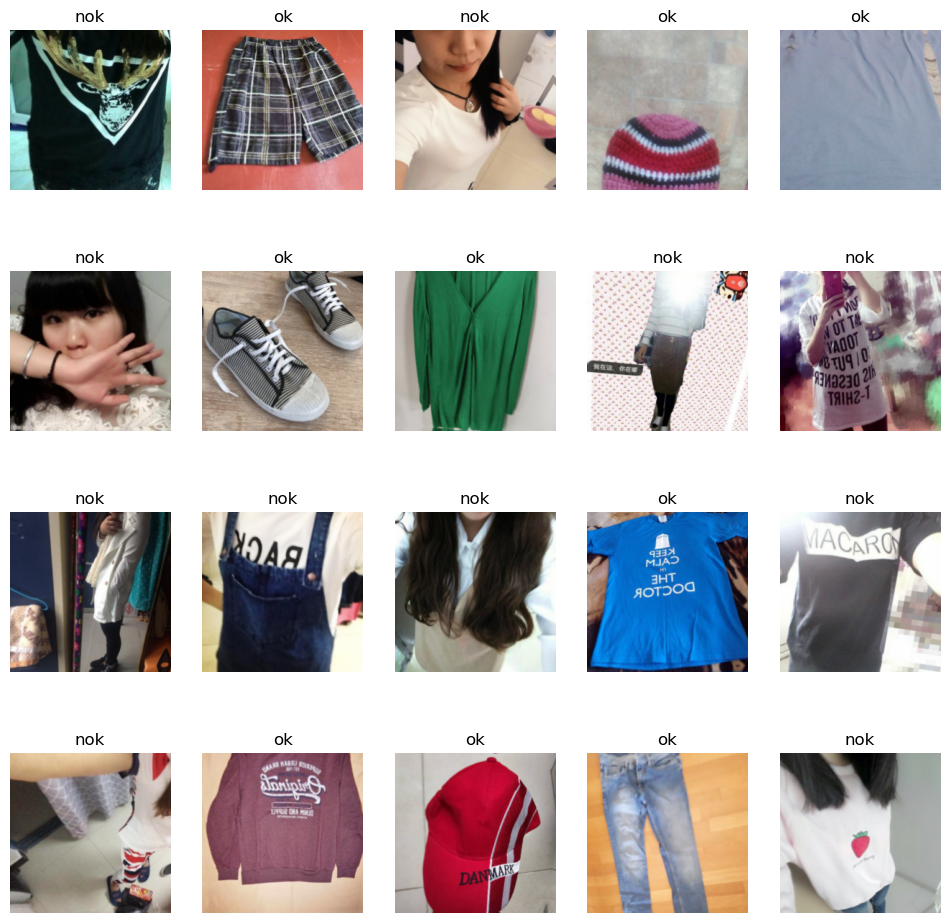

In [ ]:
# Fixe la graine aléatoire pour rendre l'entraînement reproductible
set_seed(42, reproducible=True)

# Définition du DataBlock : c’est la “recette” de ton pipeline de données fastai
dblock = DataBlock(
    
    # Le modèle doit recevoir une image (ImageBlock) et prédire une catégorie (CategoryBlock)
    blocks=(ImageBlock, CategoryBlock),
    
    # Fonction qui récupère toutes les images dans les sous-dossiers du chemin donné
    get_items=get_image_files,
    
    # Sépare les données en train/val en fonction du nom du dossier "grand-parent"
    # Exemple : dataset/train/ok/img.jpg → train
    #           dataset/val/nok/img.jpg  → val
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    
    # Le label (y) est simplement le nom du dossier parent ("ok" ou "nok")
    get_y=parent_label,
    
    # Transformation appliquée individuellement à chaque image : redimensionnement en 224x224
    item_tfms=Resize(224),
    
    # Transformations appliquées sur un batch complet (augmentations : flip, rotation…)
    batch_tfms=aug_transforms(mult=1.0)
)

# Création des DataLoaders à partir du DataBlock
# bs=64 → taille des batches (64 images par batch)
dls = dblock.dataloaders(path, bs=64)

# Affiche un batch d’images pour vérification visuelle
# max_n=20 → afficher 20 images
# figsize=(12,12) → taille du graphique
dls.show_batch(max_n=20, figsize=(12,12))

# Affiche les classes détectées (dls.vocab = ["nok", "ok"])
print("Classes :", dls.vocab)


# Création du model et entrainement

In [20]:
# Création d’un Learner fastai avec un backbone ResNet18 pré-entraîné sur ImageNet
# - dls : tes DataLoaders (images OK/NOK)
# - resnet18 : architecture du réseau de neurones
# - metrics=[accuracy] : on surveille l’accuracy sur la validation pendant l’entraînement
learn = cnn_learner(dls, resnet18, metrics=[accuracy])

# Optionnel : afficher un résumé du modèle (nombre de couches, paramètres, etc.)
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

## 📝 Résumé du modèle (ResNet18 + fastai)

* Le modèle utilise **ResNet18 pré-entraîné** sur ImageNet comme *backbone*.
* Les images d’entrée sont de taille **224×224**, en batchs de **64**.
* Fastai gèle d’abord les couches du backbone :

  * **~11,1M paramètres** ne sont pas entraînés au début (frozen)
  * seule la tête finale (~538k paramètres) est entraînée au départ
* La tête fastai ajoutée comporte :

  * Flatten
  * BatchNorm + Dropout
  * Linear → ReLU → BatchNorm → Dropout
  * Linear → **2 sorties** (OK / NOK)
* L’entraînement commence par un *fine-tuning* progressif :

  * d’abord uniquement la tête
  * puis dégel progressif du backbone
* Optimiseur : **Adam**
* Fonction de perte : **CrossEntropyLoss**
* Les *callbacks* fastai gèrent automatiquement :

  * l’affichage (ProgressCallback),
  * l’enregistrement des métriques (Recorder),
  * la séparation train/val (TrainEvalCallback).

En résumé :
**Ce modèle est un classifieur binaire OK/NOK basé sur ResNet18 pré-entraîné, avec fine-tuning progressif du backbone et une tête fastai optimisée pour la classification.**


In [21]:
# Entraînement du modèle :
# - 1 epoch pour "débloquer" la tête du réseau (fine-tuning léger)
# - puis 4 epochs supplémentaires en unfreezing automatique
# Tu peux augmenter le nombre d’epochs (par ex. fine_tune(10))
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.249296,0.105948,0.962081,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.118793,0.068686,0.978836,00:19
1,0.067478,0.059455,0.984127,00:19
2,0.054163,0.052401,0.986772,00:19
3,0.028702,0.046714,0.985891,00:19
4,0.020010,0.049132,0.984127,00:19


## 📝 Interprétation des résultats d’entraînement (`fine_tune(5)`)

Le modèle a été entraîné en deux phases :

1. **Phase 1 : 1 epoch**
   Seule la tête du réseau est entraînée (backbone gelé). Cela permet d’adapter rapidement le modèle à la tâche OK/NOK.

2. **Phase 2 : 4 epochs supplémentaires**
   Le backbone est “dégelé”, et le modèle entier est affiné sur les données (full fine-tuning).

---

### 📊 Comprendre les métriques affichées

* **Train loss**
  C’est la valeur de la fonction de perte mesurée sur le *dataset d’entraînement*.
  Elle reflète à quel point le modèle s’ajuste aux images vues pendant l’apprentissage.
  → Plus elle diminue, mieux le modèle apprend.

* **Validation loss**
  Identique à la train loss, mais calculée sur le *dataset de validation*, jamais utilisé pour entraîner le modèle.
  → C’est l’indicateur principal de la capacité du modèle à **généraliser**.
  → Si la validation loss diminue aussi, le modèle ne surapprend pas.

* **Accuracy**
  Pourcentage d’images correctement classées dans le *dataset de validation*.
  → `accuracy = (nombre de bonnes prédictions) / (nombre total d’images)`
  → Elle permet une lecture simple de la performance globale.

---

### 📈 Évolution observée pendant `fine_tune(5)`

| Phase                             | train_loss  | valid_loss   | accuracy |
| --------------------------------- | ----------- | ------------ | -------- |
| Epoch 0 (tête seule)              | ~0.25       | ~0.10        | ~0.96    |
| Epoch 1 → 4 (fine-tuning complet) | 0.12 → 0.02 | 0.06 → 0.049 | ~0.98    |

#### Points clés :

* La **train_loss diminue fortement**, signe d’un apprentissage efficace.
* La **validation loss diminue également**, preuve que le modèle ne surapprend pas.
* L’**accuracy atteint ~98.4 %**, un excellent résultat pour un classifieur binaire OK/NOK.
* L’absence d’écart important entre train_loss et valid_loss indique que le modèle **généralise bien**.

---

### ✔ Conclusion

Le modèle converge proprement, apprend les caractéristiques OK/NOK de manière stable, et fournit d’excellentes performances sur le jeu de validation. Il est maintenant prêt pour une évaluation plus poussée via la matrice de confusion, l’analyse des erreurs (top_losses) ou l’évaluation sur un jeu de test indépendant.

---

Si tu veux, je peux aussi te rédiger la cellule Markdown expliquant la **matrice de confusion**, ou une cellule Markdown pour expliquer les **top erreurs (top_losses)**.
Voici une version enrichie de ta cellule Markdown, incluant **l’explication des métriques** : *train_loss*, *valid_loss* et *accuracy*.
Tu peux la coller telle quelle dans ton Notebook.

---

## 📝 Interprétation des résultats d’entraînement (`fine_tune(5)`)

Le modèle a été entraîné en deux phases :

1. **Phase 1 : 1 epoch**
   Seule la tête du réseau est entraînée (backbone gelé). Cela permet d’adapter rapidement le modèle à la tâche OK/NOK.

2. **Phase 2 : 4 epochs supplémentaires**
   Le backbone est “dégelé”, et le modèle entier est affiné sur les données (full fine-tuning).

---

### 📊 Comprendre les métriques affichées

* **Train loss**
  C’est la valeur de la fonction de perte mesurée sur le *dataset d’entraînement*.
  Elle reflète à quel point le modèle s’ajuste aux images vues pendant l’apprentissage.
  → Plus elle diminue, mieux le modèle apprend.

* **Validation loss**
  Identique à la train loss, mais calculée sur le *dataset de validation*, jamais utilisé pour entraîner le modèle.
  → C’est l’indicateur principal de la capacité du modèle à **généraliser**.
  → Si la validation loss diminue aussi, le modèle ne surapprend pas.

* **Accuracy**
  Pourcentage d’images correctement classées dans le *dataset de validation*.
  → `accuracy = (nombre de bonnes prédictions) / (nombre total d’images)`
  → Elle permet une lecture simple de la performance globale.

---

### 📈 Évolution observée pendant `fine_tune(5)`

| Phase                             | train_loss  | valid_loss   | accuracy |
| --------------------------------- | ----------- | ------------ | -------- |
| Epoch 0 (tête seule)              | ~0.25       | ~0.10        | ~0.96    |
| Epoch 1 → 4 (fine-tuning complet) | 0.12 → 0.02 | 0.06 → 0.049 | ~0.98    |

#### Points clés :

* La **train_loss diminue fortement**, signe d’un apprentissage efficace.
* La **validation loss diminue également**, preuve que le modèle ne surapprend pas.
* L’**accuracy atteint ~98.4 %**, un excellent résultat pour un classifieur binaire OK/NOK.
* L’absence d’écart important entre train_loss et valid_loss indique que le modèle **généralise bien**.

---

### ✔ Conclusion

Le modèle converge proprement, apprend les caractéristiques OK/NOK de manière stable, et fournit d’excellentes performances sur le jeu de validation. Il est maintenant prêt pour une évaluation plus poussée via la matrice de confusion, l’analyse des erreurs (top_losses) ou l’évaluation sur un jeu de test indépendant.

In [22]:
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

## 📝 Résumé du modèle après `fine_tune(5)`

Après le fine-tuning, tout le modèle a été **débloqué (unfrozen)** :

* **Tous les paramètres du backbone ResNet18 sont maintenant entraînables.**
  → Les 11,7M paramètres sont optimisés (au lieu de seulement ~0,5M au début).
* Le modèle effectue un **apprentissage complet (full fine-tuning)** sur les données OK/NOK.

Changements clés visibles dans le summary :

* Toutes les couches `Conv2d` et `BatchNorm2d` sont maintenant marquées **Trainable = True**.
* La tête du modèle (BatchNorm1d + Linear + Dropout) reste bien sûr elle aussi entraînable.
* `Total trainable params` est maintenant égal à **11,704,896**
  → Aucun paramètre n’est gelé.
* `Total non-trainable params` est maintenant **0**.
* L’optimiseur reste **Adam**, adapté au fine-tuning complet.
* La loss utilisée reste **CrossEntropyLoss**, standard pour une classification binaire.
* Le modèle indique explicitement : **Model unfrozen**.

En résumé :
**Ce modèle ResNet18 est maintenant entièrement affiné sur ton dataset OK/NOK, et tous ses paramètres sont mis à jour pour optimiser les performances sur ta tâche.**


## Interprétation

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

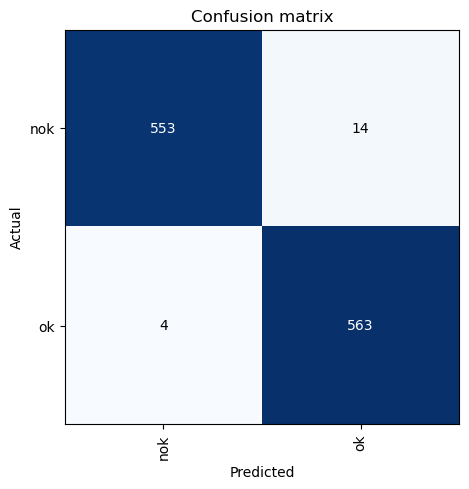

In [25]:
interp.plot_confusion_matrix()

## 📝 Analyse de la matrice de confusion

Voici l’interprétation des résultats obtenus :

### **Vrais Positifs (VP)**

**563**
Images réellement *ok* correctement classées comme *ok*.
→ Le modèle reconnaît très bien les vêtements isolés.

### **Vrais Négatifs (VN)**

**553**
Images réellement *nok* correctement classées comme *nok*.
→ Le modèle identifie correctement les images contenant des personnes.

---

### **Faux Positifs (FP)**

**14**
Images *nok* classées à tort comme *ok*.
→ Ce sont les erreurs les plus importantes pour cette tâche :
des images contenant des personnes sont prises pour des images correctes.

### **Faux Négatifs (FN)**

**4**
Images *ok* classées à tort comme *nok*.
→ Le modèle rejette inutilement quelques vêtements isolés (moins problématique dans ton cas d’usage).

---

### ✔ En résumé

* Le modèle fait très peu d’erreurs.
* Les *faux positifs* (nok → ok) sont rares (14 cas), mais méritent attention.
* Les *faux négatifs* (ok → nok) sont quasiment inexistants (4 cas).
* La performance globale est excellente pour un classifieur binaire OK/NOK.

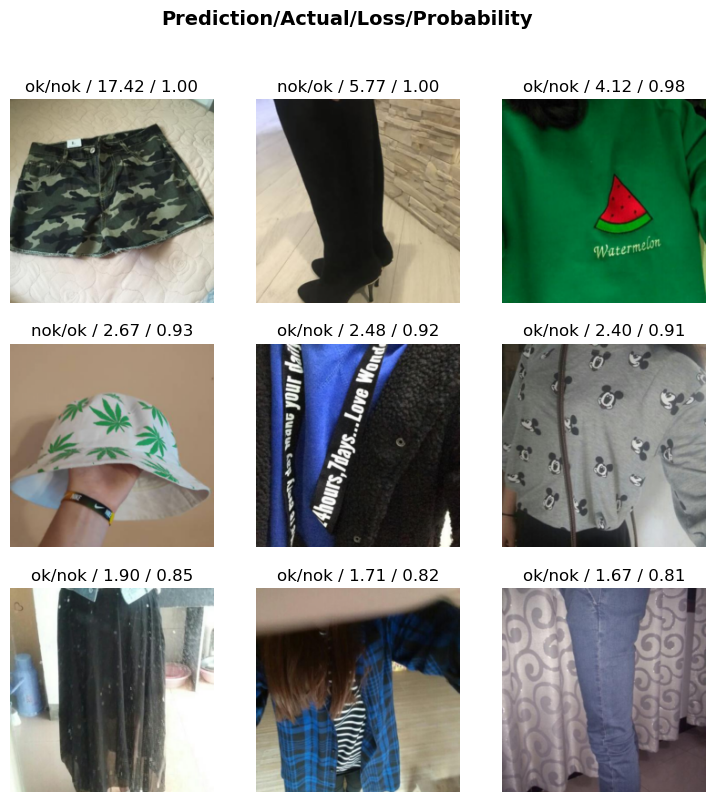

In [26]:
interp.plot_top_losses(9, nrows=3)